In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from datetime import datetime
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

2023-07-01 20:51:11.323497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 20:51:17.364335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-01 20:51:17.364422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-01 20:51:17.973672: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-01 20:51:29.573560: W tensorflow/stream_executor/platform/de

In [2]:
# Sample a sliding window for each data point i.e. sample the data
def create_train_data(df_train, n_steps):
  X, Y = list(), list()
  for i in range(len(df_train)):
    sam = i + n_steps
    if sam > len(df_train)-1:
        break
    x, y = df_train.iloc[i:sam], df_train.iloc[sam]
    X.append(x)

    Y.append(y)
  X = np.array(X)
  Y = np.array(Y)
  # Get the correct shape for the data
  X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
  Y = np.reshape(Y, (Y.shape[0], 1, Y.shape[1]))
  return X, Y

In [3]:
# Sample a sliding window for each data point i.e. sample the data
def create_test_data(df_train, df_test, n_steps):
  X, Y = list(), list()
  for i in range(len(df_test)):
    # if current step in the new df is smaller than the step size, we need old data
    if(i < n_steps):
      # How many old values do we need
      number_old = n_steps - i
      x = df_train.iloc[len(df_train)-number_old:len(df_train)]
      # append the new values
      x = x.append(df_test.iloc[0:i])
      y = df_test.iloc[i]
    else:
      x, y = df_test.iloc[i-n_steps:i], df_test.iloc[i]
    X.append(x)

    Y.append(y)
  X = np.array(X)
  Y = np.array(Y)
  # Get the correct shape for the data
  X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
  Y = np.reshape(Y, (Y.shape[0], 1, Y.shape[1]))
  return X, Y

In [4]:
def scale_data_train(df_train):
    sc = MinMaxScaler()
    df_train["cpu"] = sc.fit_transform(df_train["cpu"].values.reshape(-1, 1))
    return sc, df_train

In [5]:
def scale_data_test(df_test, sc):
    df_test["cpu"] = sc.transform(df_test["cpu"].values.reshape(-1, 1))
    return df_test

In [6]:
def get_data(window_size):
    # full_df = pd.read_csv(r"C:\Users\simon\Nextcloud\programmingProjects\freelancer\projects\2022-09-01_NeuralNetwork_cpu_utilization\data\data_2\archive\cpu-full-a.csv")
    # Load the data
    df_train = pd.read_csv(r"data/data_2/archive/cpu-train-a.csv")
    df_test = pd.read_csv(r"data/data_2/archive/cpu-test-a.csv")

    # Make datetime to index
    df_train = df_train.set_index("datetime")
    df_train = df_train.sort_index()
    
    df_test = df_test.set_index("datetime")
    df_test = df_test.sort_index()
    
    
    scaler, df_train = scale_data_train(df_train)
    
    df_test = scale_data_test(df_test, scaler)
    
    # Create datasets
    x_train, y_train = create_train_data(df_train, window_size)
    
    x_test, y_test = create_test_data(df_train, df_test, window_size) 
    
    return scaler, x_train, y_train, x_test, y_test

In [7]:
from keras.layers.core import Lambda
from keras import backend as K

def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

In [26]:
def create_model(x_train, y_train, window_size):
    # # Make tensors because of custom loss function
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(1, window_size), return_sequences=True))
    model.add(PermaDropout(0.3))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse')
    history = model.fit(x_train, y_train, epochs=20, batch_size=200, validation_split=0.1,verbose=0)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return model

In [27]:
def predict_confidence(model, value, iterations):
    # Predict confidence and value 
    predictions = []
    for i in range(iterations):
        predictions.append(model.predict(value))        
    

In [28]:
def plot_differences(predicted, orig):
    x = [i for i in range(len(predicted))]
    plt.plot(x, predicted)
    plt.plot(x, orig)
    plt.show()

/tmp/ipykernel_6310/2447839638.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(df_test.iloc[0:i])
/tmp/ipykernel_6310/2447839638.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(df_test.iloc[0:i])
/tmp/ipykernel_6310/2447839638.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(df_test.iloc[0:i])
/tmp/ipykernel_6310/2447839638.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.append(df_test.iloc[0:i])
/tmp/ipykernel_6310/2447839638.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = x.a

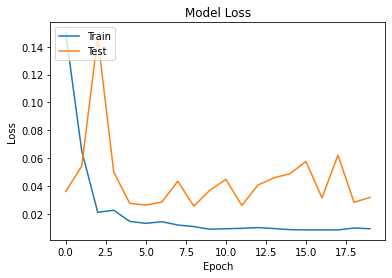

9/9 [==============================] - 1s 7ms/step


In [29]:
# Parameters:
window_size = 150


scaler, x_train, y_train, x_test, y_test = get_data(window_size)
model = create_model(x_train, y_train, window_size)

train_predict = model.predict(x_train)

In [30]:
print(x_train)

[[[0.28787879 0.26767677 0.26262626 ... 0.25757576 0.24242424 0.27777778]]

 [[0.26767677 0.26262626 0.25757576 ... 0.24242424 0.27777778 0.31313131]]

 [[0.26262626 0.25757576 0.25757576 ... 0.27777778 0.31313131 0.28282828]]

 ...

 [[0.46969697 0.42929293 0.43434343 ... 0.92424242 0.92929293 0.8030303 ]]

 [[0.42929293 0.43434343 0.40909091 ... 0.92929293 0.8030303  0.68686869]]

 [[0.43434343 0.40909091 0.37878788 ... 0.8030303  0.68686869 0.79292929]]]


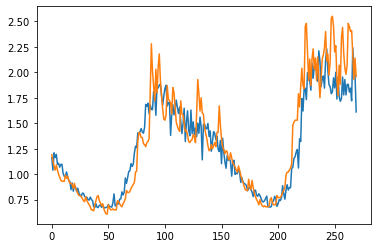

In [31]:
rescaled_predicted = scaler.inverse_transform(train_predict.reshape(-1, 1))
rescaled_y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
plot_differences(rescaled_predicted, rescaled_y_train)

train mean_squared_error model
0.04665060427072255
train mean_squared_error naive forecast
0.017615867158671583


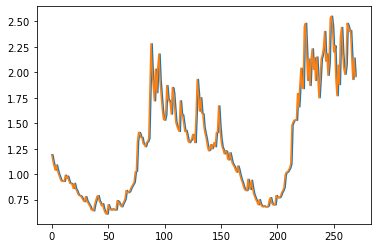

In [35]:
from sklearn.metrics import mean_squared_error

# calcular el mean_squared_error de la prediccion
mse = mean_squared_error(rescaled_y_train, rescaled_predicted)

print('train mean_squared_error model')
print(mse)

# calcular el mean_squared_error de la prediccion naive forecast

pred_naive = np.insert(rescaled_y_train, 0, rescaled_y_train[0])
y_train_naive = np.insert(rescaled_y_train, rescaled_y_train.size, rescaled_y_train[rescaled_y_train.size-1])

mse = mean_squared_error(y_train_naive, pred_naive)

print('train mean_squared_error naive forecast')
print(mse)

plot_differences(pred_naive, y_train_naive.reshape(-1, 1))

[0.62454915, 0.57538337, 0.6280661, 0.64890206, 0.51288074, 0.5233568, 0.5589111, 0.553036, 0.56952786, 0.5876553, 0.5383144, 0.53478855, 0.5532363, 0.5612955, 0.5731935, 0.5484331, 0.5681608, 0.5225804, 0.5215427, 0.51534384, 0.5185386, 0.52425545, 0.53338283, 0.48075113, 0.47543076, 0.5009693, 0.5362821, 0.5461345, 0.465265, 0.4321495, 0.54276055, 0.40336108, 0.46324915, 0.4766042, 0.442224, 0.52058285, 0.34753978, 0.41982234, 0.39022157, 0.37689754, 0.36015996, 0.4030519, 0.38423833, 0.429121, 0.3587394, 0.39232337, 0.45228046, 0.38896897, 0.38264772, 0.27180567, 0.2724401, 0.25348166, 0.22882253, 0.24553934, 0.16882926, 0.1766948, 0.15793966, 0.18048604, 0.12545213, 0.1334563]
[[1.8066074 ]
 [1.7092592 ]
 [1.813571  ]
 [1.8548261 ]
 [1.5855039 ]
 [1.6062465 ]
 [1.676644  ]
 [1.6650113 ]
 [1.6976652 ]
 [1.7335576 ]
 [1.6358626 ]
 [1.6288813 ]
 [1.6654079 ]
 [1.6813651 ]
 [1.7049232 ]
 [1.6558976 ]
 [1.6949583 ]
 [1.6047093 ]
 [1.6026547 ]
 [1.5903809 ]
 [1.5967065 ]
 [1.6080258 ]
 [

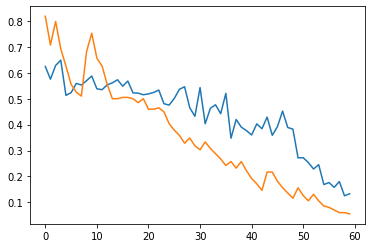

In [23]:
# create test predictions
start_window = x_test.tolist()
start_window = start_window[0][0]
predictions = []
for i in range(len(y_test)):
    new_val = model.predict([[start_window]], verbose=0)
    predictions.append(new_val[0][0])

    # plt.plot(start_window, label='Real data')
    # plt.plot(len(start_window), new_val[0][0], "bx", markersize=10, label='Predicted data', color='red')
    # plt.show()
    
    start_window.append(float(new_val[0][0]))
    start_window = start_window[1:]

print(predictions)
print(scaler.inverse_transform(np.array(predictions).reshape(-1,1)))

plot_differences(predictions, y_test.reshape(-1, 1))

mean_squared_error model
0.020649073051391804
mean_squared_error naive forecast
0.002021791018313621


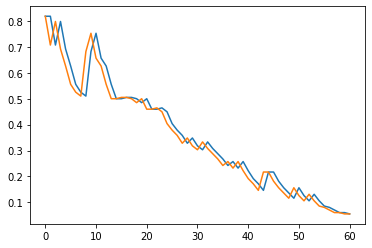

In [34]:
from sklearn.metrics import mean_squared_error

# calcular el mean_squared_error de la prediccion
rescaled_y_test = y_test.reshape(-1, 1)
mse = mean_squared_error(rescaled_y_test, predictions)

print('mean_squared_error model')
print(mse)

# calcular el mean_squared_error de la prediccion naive forecast

pred_naive_test = np.insert(rescaled_y_test, 0, rescaled_y_test[0])
y_test_naive = np.insert(rescaled_y_test, rescaled_y_test.size, rescaled_y_test[rescaled_y_test.size-1])

mse = mean_squared_error(y_test_naive, pred_naive_test)

print('mean_squared_error naive forecast')
print(mse)

plot_differences(pred_naive_test, y_test_naive.reshape(-1, 1))

In [16]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.85):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [17]:
start_window = x_test.tolist()
start_window = start_window[0][0]
predictions = []
for i in range(20):
    predictions.append(model.predict([[start_window]], verbose = 0)[0][0])

pred_mean, upper_conf, lower_conf = mean_confidence_interval(predictions)
print(pred_mean)
print(upper_conf)
print(lower_conf)
print(start_window)

0.59601784
0.5785413524553831
0.613494322593445
[0.40909090909090906, 0.3787878787878789, 0.3737373737373738, 0.383838383838384, 0.38888888888888906, 0.41414141414141414, 0.4040404040404042, 0.3737373737373738, 0.5151515151515152, 0.686868686868687, 0.6161616161616162, 0.5303030303030305, 0.595959595959596, 0.5202020202020203, 0.5151515151515152, 0.4494949494949495, 0.4191919191919192, 0.39393939393939403, 0.3585858585858587, 0.33333333333333337, 0.33838383838383845, 0.36363636363636376, 0.34343434343434354, 0.3585858585858587, 0.3737373737373738, 0.3535353535353536, 0.4242424242424243, 0.4242424242424243, 0.5555555555555556, 0.45959595959595967, 0.39393939393939403, 0.3535353535353536, 0.33838383838383845, 0.31818181818181823, 0.33333333333333337, 0.3282828282828283, 0.29292929292929293, 0.28787878787878785, 0.3232323232323233, 0.297979797979798, 0.2727272727272728, 0.26262626262626276, 0.2525252525252526, 0.23737373737373746, 0.2272727272727274, 0.2575757575757577, 0.2373737373737374

In [19]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix,0, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix,0, :]), len(series[ix,0, :])+len(y[ix])), y[ix], "bx", markersize=10)
        # if y_pred is not None:
        #     plt.plot(range(len(series[ix,0, :]), len(series[ix,0, :])+len(y_pred[ix])), y_pred[ix], "ro")
        # if y_pred_std is not None:
        #     plt.plot(range(len(series[ix,0, :]), len(series[ix,0, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
        #     plt.plot(range(len(series[ix,0, :]), len(series[ix,0, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        # plt.grid(True)
        # plt.hlines(0, 0, 100, linewidth=1)
        # plt.axis([0, len(series[ix,0, :])+len(y[ix]), -1, 1])
        # if x_label and row == r - 1:
        #   plt.xlabel(x_label, fontsize=16)
        # if y_label and col == 0:
        #   plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

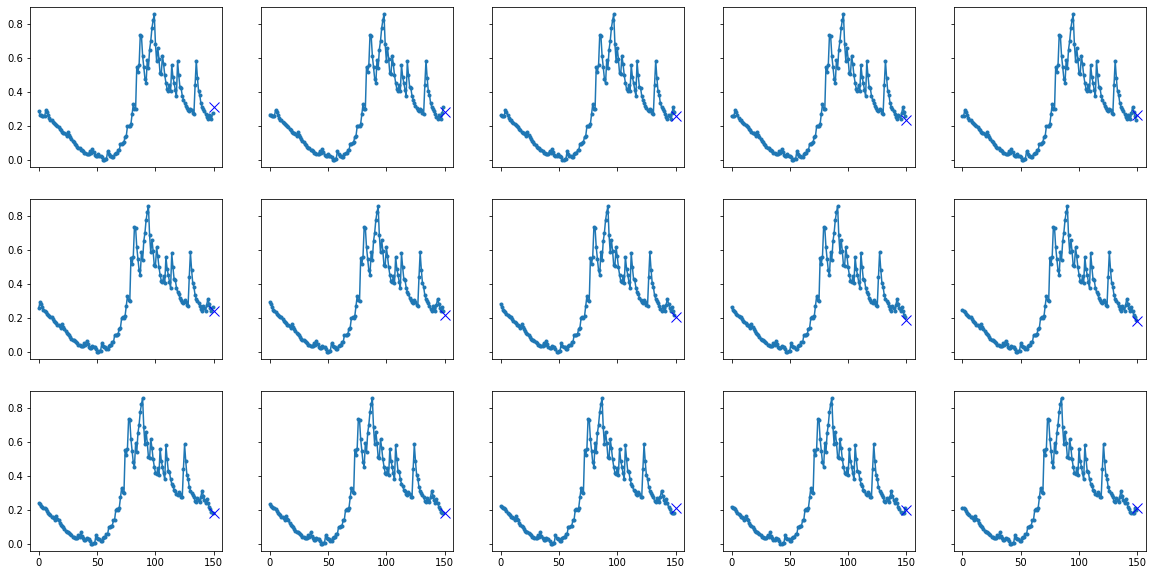

In [34]:
x_train.shape, y_train.shape
plot_series(x_train, y_train)

In [20]:
x_train.shape, y_train.shape

((270, 1, 150), (270, 1, 1))

/tmp/ipykernel_6310/3799251989.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx" (-> color='b'). The keyword argument will take precedence.
  plt.plot(len(data), predicted_data, "bx", markersize=10, label='Predicted data', color='red')


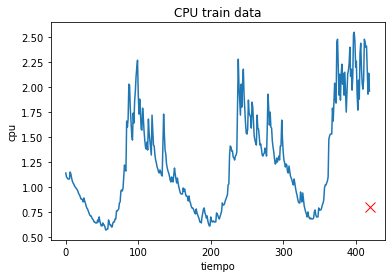

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Carga los datos del archivo CSV
df = pd.read_csv(r"data/data_2/archive/cpu-train-a.csv")

# Selecciona la columna que deseas graficar
data = df['cpu']

predicted_data = 0.8

# Grafica los datos utilizando un gráfico de línea
plt.plot(data, label='Real data')
plt.plot(len(data), predicted_data, "bx", markersize=10, label='Predicted data', color='red')


# Agrega títulos y etiquetas de eje al gráfico
plt.title('CPU train data')
plt.xlabel('tiempo')
plt.ylabel('cpu')

# Muestra el gráfico en pantalla
plt.show()